In [1]:
%load_ext autoreload


In [2]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
import cmasher as cmr
import corner    
import multiprocessing as mpr
mpr.set_start_method('fork')
#import gp_init_threads as th_init
from all_prof_functions import (run_each_gp, plot_recon_profs)

%aimport -os -np -plt -cmr -mpr -corner
%autoreload 2


In [3]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = False #### Change this to switch between dark and light backgrounds for plots (True == dark) #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [4]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'B1540-06'
freq = 1400
be = 'dfb'


In [5]:
be = be.lower()
BE = be.upper()
desc = "{}_{}_{}".format(psr, be, freq)
npz_file = os.path.join(data_dir, psr+'_{}_eigs.npz'.format(freq))
if not os.path.exists(npz_file):
    raise(RuntimeError("File containing eigenvalues does not exist"))

nudot_file = os.path.join(data_dir, psr+"_nudot_gp.txt") # contains columns of MJD, nudot, uncertainty


In [6]:
exist_BE = True
with np.load(npz_file, allow_pickle=True) as d:
    if BE+'_errs' in d.keys():
        BE_errs = d[BE+'_errs']
        BE_mean = d[BE+'_mean']
        BE_eigval = d[BE+'_values']
        BE_eigvec = d[BE+'_vectors']
        BE_eigval_bin = d[BE+'_bin_vals']
        BE_mjds = d[BE+'_mjds']
        BE_mjds_bin = d[BE+'_bin_mjds']
        BE_rms = d[BE+'_rms']
    else:
        exist_BE = False
        
if exist_BE:
    print("The shape of the {} eigval array is {}.".format(BE, BE_eigval.shape))
    if len(BE_errs) == BE_eigval.shape[0] and len(BE_mean) == BE_eigvec.shape[1] and BE_eigval.shape[1] == BE_eigvec.shape[0] \
        and BE_eigval.shape[0] == len(BE_mjds) and BE_eigval.shape[0] == len(BE_rms) and BE_eigval_bin.shape[0] == len(BE_mjds_bin):
        print("All {} shapes and lengths agree".format(BE))
    else:
        print("WARNING: Lengths and shapes for {} do not agree!".format(BE))


Binning was done with a length scale of 400.
The shape of the AFB eigval array is (338, 30).
All AFB shapes and lengths agree
The shape of the DFB eigval array is (171, 30).
All DFB shapes and lengths agree


<Figure size 640x480 with 0 Axes>

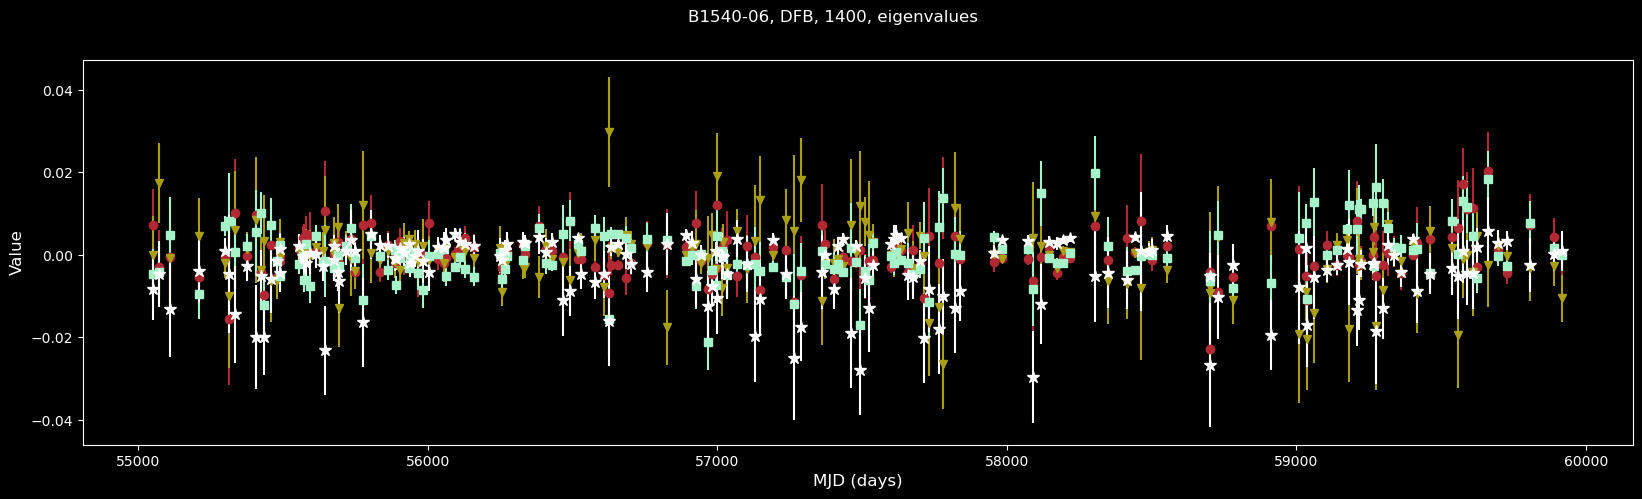

In [7]:
if exist_BE and True:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, {}, {}, eigenvalues".format(psr, BE, freq))
        ax1 = fig.gca()
        ax1.errorbar(BE_mjds, BE_eigval[:,3], yerr=BE_errs[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(BE_mjds, BE_eigval[:,2], yerr=BE_errs[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(BE_mjds, BE_eigval[:,1], yerr=BE_errs[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(BE_mjds, BE_eigval[:,0], yerr=BE_errs[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)


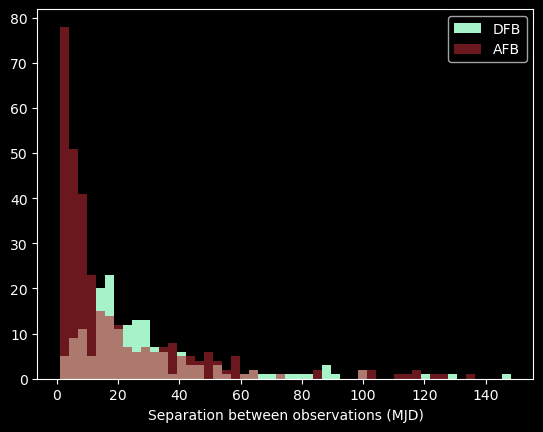

In [8]:
with plt.style.context(plot_style):
    plt.clf()
    if exist_BE:
        _ = plt.hist(BE_mjds[1:] - BE_mjds[:-1], bins=50, color=c2, label=BE)
        
    if exist_BE:
        plt.xlabel("Separation between observations (MJD)")
        plt.legend()
        plt.show()


In [9]:
# read in the MJDs from the nudot GP file to make alignment (for finding correlations) easier
if not os.path.exists(nudot_file):
    print("WARNING: File containing nu-dot GPs does not exist")
    BE_mjds_pred = None
else:
    nudot_mjds = np.loadtxt(nudot_file, unpack=True, usecols=(0,))
    avg_sep = np.mean(nudot_mjds[1:] - nudot_mjds[:-1]) # separation between nudot MJDs        
    if exist_BE:
        nudot_min = min(nudot_mjds)
        nudot_max = max(nudot_mjds)
        BE_min = min(BE_mjds)
        BE_max = max(BE_mjds)
        if nudot_min > BE_min:
            num_pre = int(np.ceil((nudot_min - BE_min)/avg_sep)) # number of points needed to fill
            new_min = nudot_min - avg_sep*num_pre # shift the minimum to use an integer
            pre_mjds = np.linspace(new_min, nudot_min, num_pre, endpoint=False)
            nudot_mjds = np.append(pre_mjds, nudot_mjds)
    
        if nudot_max < BE_max:
            num_post = int(np.ceil((BE_max - nudot_max)/avg_sep)) # number of points needed to fill
            new_max = nudot_max + avg_sep*num_post # shift the maximum to use an integer
            post_mjds = np.linspace(nudot_max, new_max, num_post, endpoint=False)
            nudot_mjds = np.append(nudot_mjds, post_mjds)

        BE_mjds_pred = nudot_mjds[nudot_mjds >= min(BE_mjds)-0.1]
        BE_mjds_pred = np.unique(BE_mjds_pred) # this shouldn't be necessary... why is it?
    
    print("The MJDs for the GP prediction span from {:.5f} to {:.5f} with an average separation of {:.3f}".format(min(nudot_mjds), max(nudot_mjds), avg_sep))
    if np.any(nudot_mjds != sorted(nudot_mjds)):
        print("Nudot MJDs are not sorted!!")
    

The MJDs for the GP prediction span from 46236.37397 to 59917.35342 with an average separation of 11.614


Running GP for DFB data
The minimum length scale for DFB is 97.45
Subtracting 55052 from MJDs (will return true MJD values)
The initial parameter vector is [ 0.00000000e+00  6.18758454e+00 -4.90252084e+00 -3.56542805e-03]
Running burn-in


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 115.91it/s]


Running second burn-in


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 112.72it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:33<00:00, 89.36it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [211.89973099 185.11164131 196.71801012  88.59358995]


The array of autocorrelation times is [211.89973099 185.11164131 196.71801012  88.59358995]


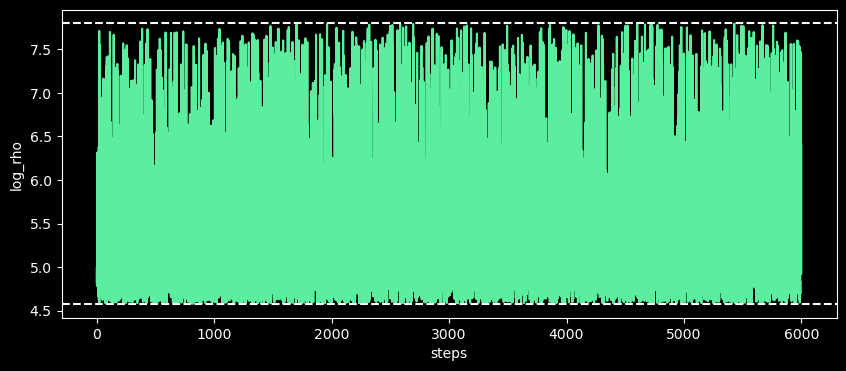

The bounds returned by the attribute are [(-15, 15), (4.579367781605976, 7.797022456729247), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

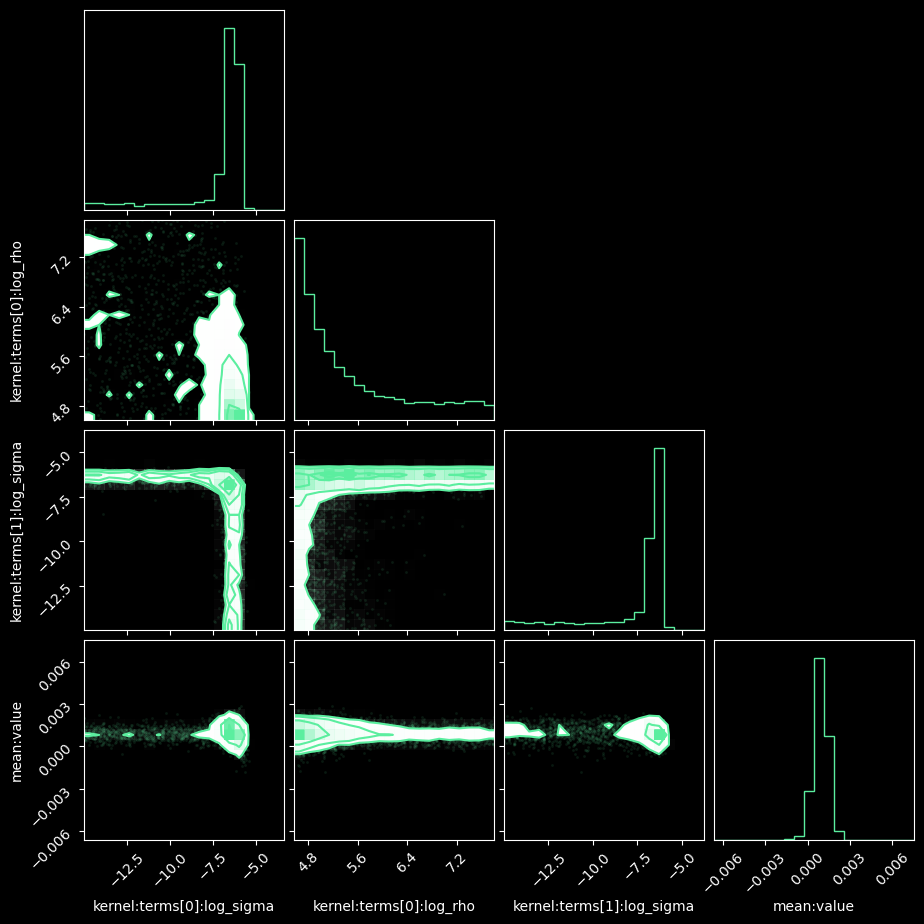

The initial parameter vector is [ 0.00000000e+00  6.18758454e+00 -5.06914805e+00  2.16469751e-04]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 75.81it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 74.45it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:39<00:00, 76.66it/s]
N/50 = 60;
tau: [54.79232169 61.73650456 69.21502722 51.93585779]


The array of autocorrelation times is [54.79232169 61.73650456 69.21502722 51.93585779]


<Figure size 640x480 with 0 Axes>

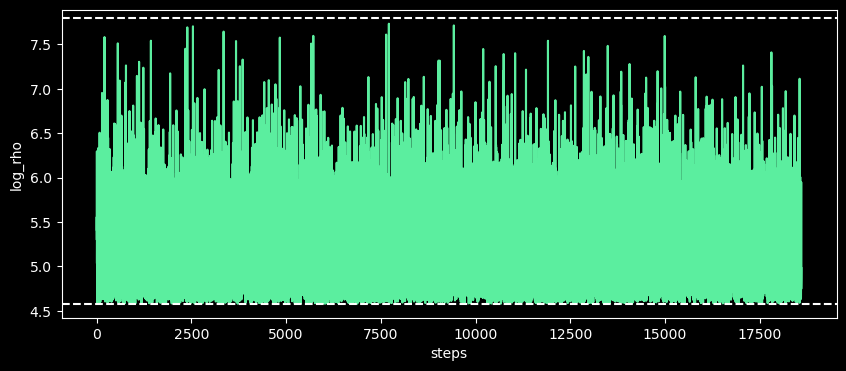

The bounds returned by the attribute are [(-15, 15), (4.579367781605976, 7.797022456729247), (-15, 15), (None, None)]
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

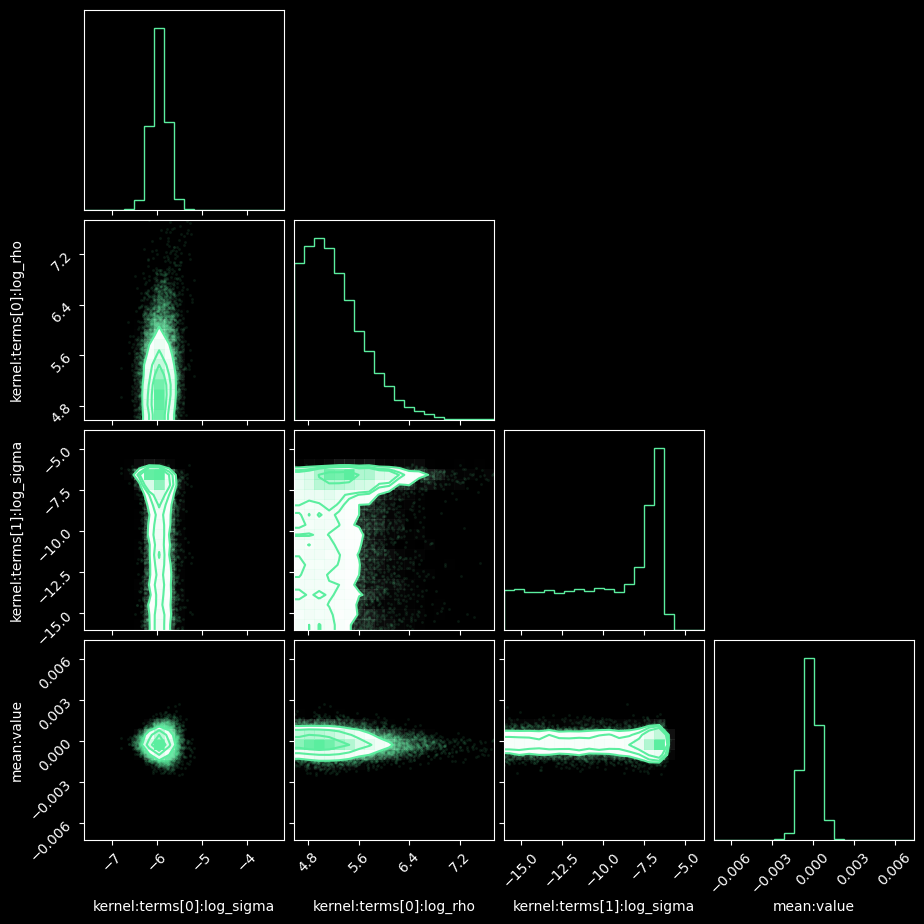

The initial parameter vector is [ 0.00000000e+00  6.18758454e+00 -4.93594702e+00 -3.58404574e-04]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 78.74it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 75.36it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:35<00:00, 83.94it/s]
N/50 = 60;
tau: [70.03253372 71.47623653 75.45369414 56.94959152]


The array of autocorrelation times is [70.03253372 71.47623653 75.45369414 56.94959152]


<Figure size 640x480 with 0 Axes>

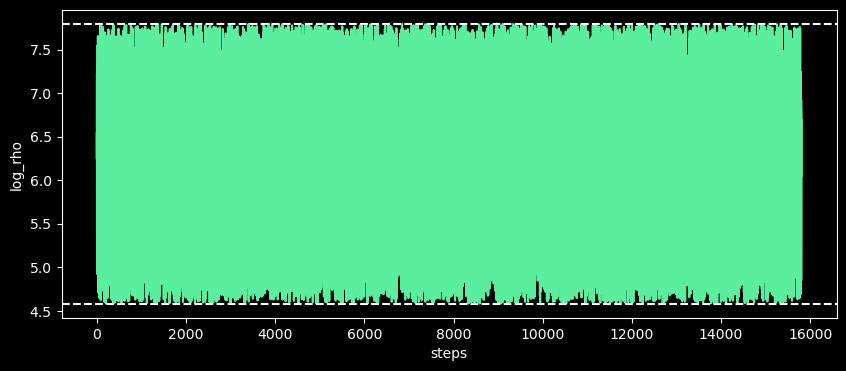

The bounds returned by the attribute are [(-15, 15), (4.579367781605976, 7.797022456729247), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

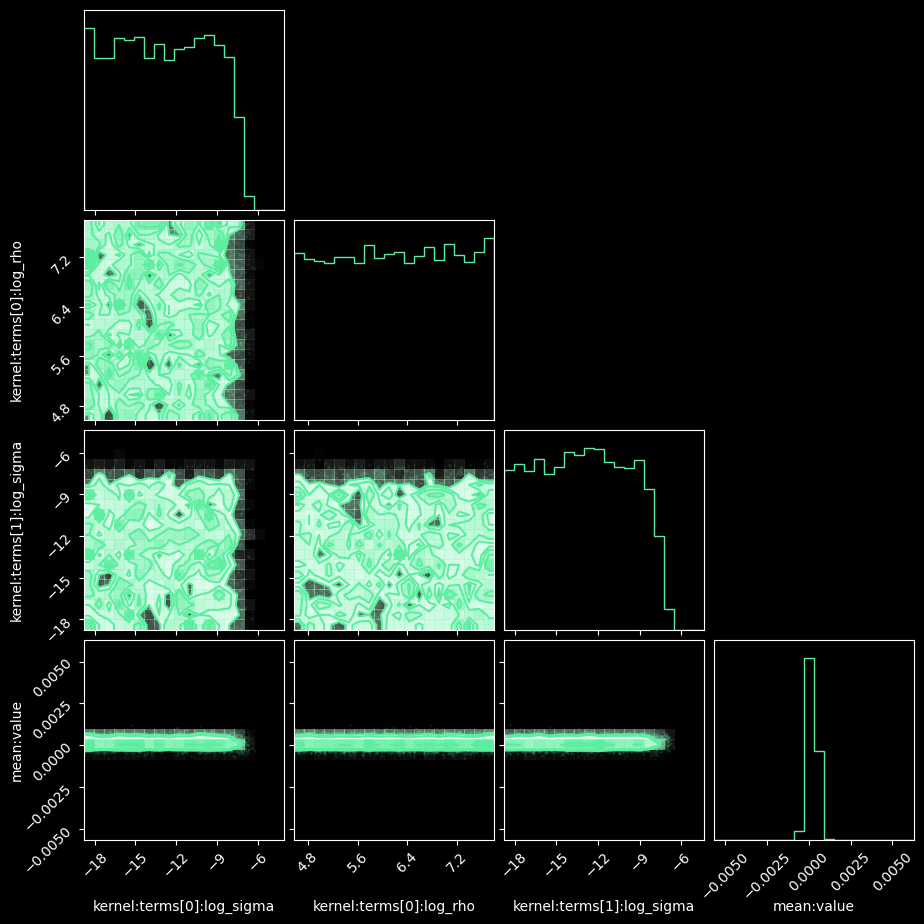

The initial parameter vector is [ 0.00000000e+00  6.18758454e+00 -5.22297382e+00  2.91579461e-04]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 79.60it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 71.85it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:35<00:00, 83.52it/s]
N/50 = 60;
tau: [68.59760242 69.75978899 69.99993426 54.77694971]


The array of autocorrelation times is [68.59760242 69.75978899 69.99993426 54.77694971]


<Figure size 640x480 with 0 Axes>

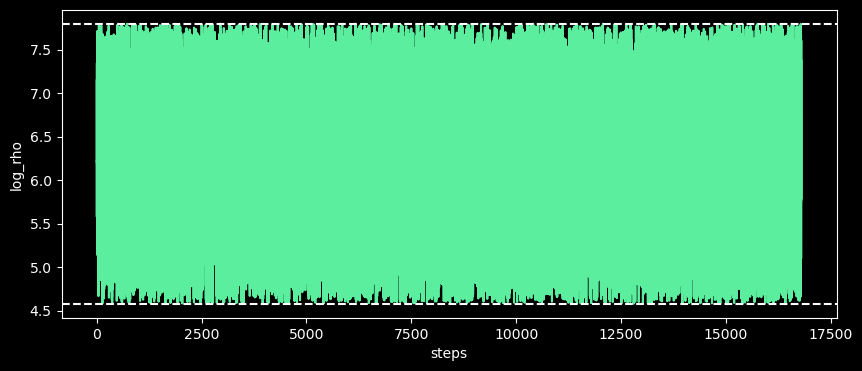

The bounds returned by the attribute are [(-15, 15), (4.579367781605976, 7.797022456729247), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

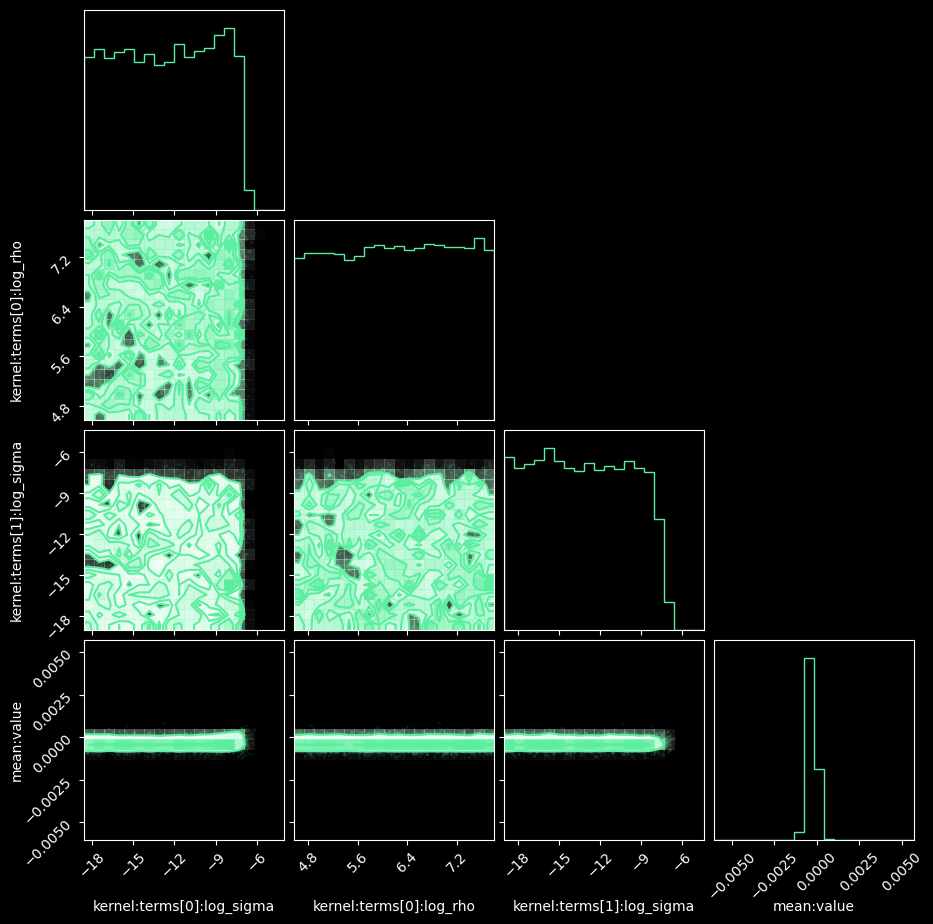

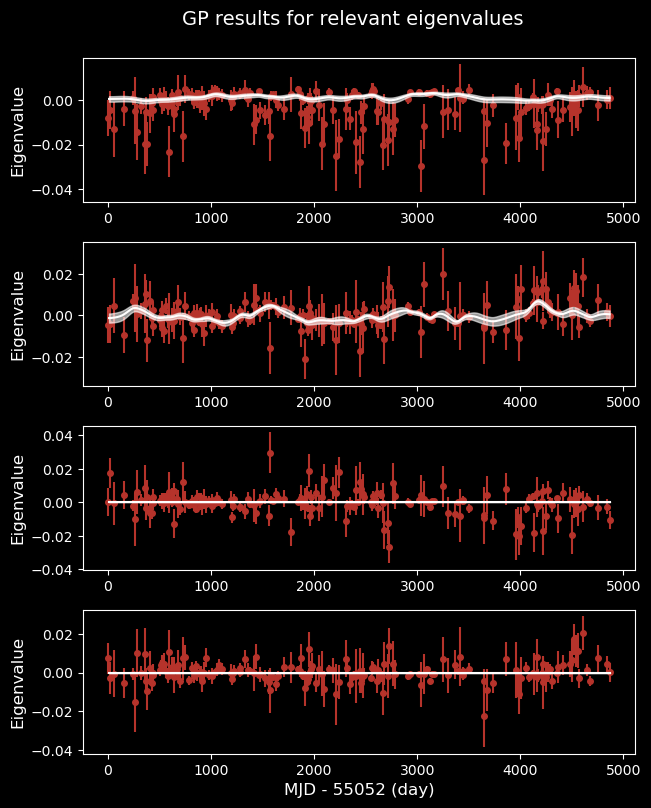

In [10]:
read_old = False
gp_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
if read_old and os.path.exists(gp_file):
    with np.load(gp_file, allow_pickle=True) as d:
        if exist_BE and BE+'_mjds_pred' in d.keys():
            BE_mjds_pred = d[BE+'_mjds_pred']
            BE_pred_vars = d[BE+'_vars_pred']
            BE_pred_res = d[BE+'_res_pred']
        else:
            print("No {} arrays in npz file".format(BE))
            
if exist_BE and BE+'_pred_res' not in locals():
    print("Running GP for {} data".format(BE))
    lags = BE_mjds[1:] - BE_mjds[:-1]
    pmin = np.percentile(lags, 97.5)
    print("The minimum length scale for {} is {:.2f}".format(BE, pmin))
    mjd_range = BE_mjds[-1] - BE_mjds[0]
    kern_len = max(pmin*2, mjd_range/10)

    BE_pred_res, BE_pred_vars, BE_mjds_pred = run_each_gp(BE_eigval, BE_mjds, BE_errs, kern_len=kern_len, max_num=3, # adjust this number as necessary
                                                             prior_min=pmin, prior_max=0.5*mjd_range, mjds_pred=BE_mjds_pred,
                                                             burn_chain=300, prod_chain=3000, num_walkers=200, # these values can be adjusted but should work
                                                             plot_chains=True, plot_corner=True, plot_gps=True, mcmc=True, multi=True,
                                                             verb=True, bk_bgd=use_bk_bgd, gp_plotname=os.path.join(plots_dir, desc+'_gp_preds.png'.format(freq)))


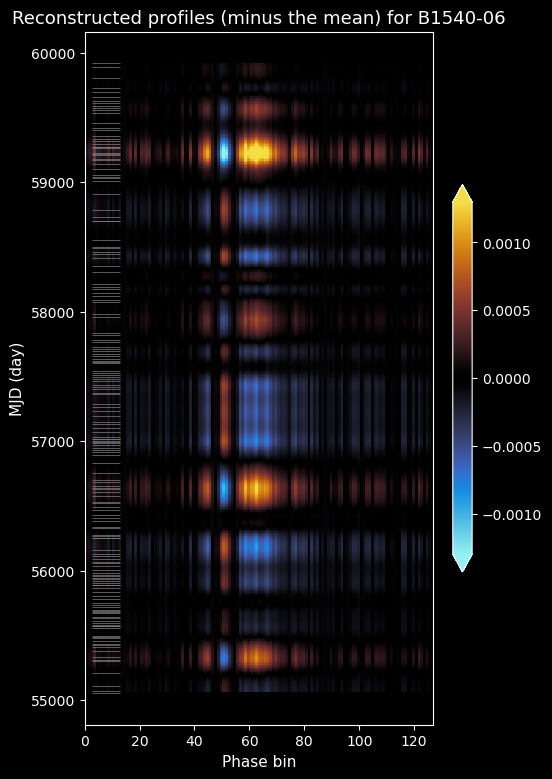

In [12]:
if exist_BE:
    plot_recon_profs(BE_mean, BE_eigvec[1:], BE_mjds_pred, BE_pred_res[1:,], psr, mjds_real=BE_mjds, bk_bgd=use_bk_bgd,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_BE_recon_wfall.png'))
    

We want to save the arrays containing GP predicted values, so the following cells will check if an older file exists (which may contain arrays for different datasets), read that into a separate dictionary, and write both dictionaries to the '.npz' file. 

In [14]:
var_dict = {}
if exist_BE:
    var_dict[BE+'_mjds_pred'] = BE_mjds_pred
    var_dict[BE+'_res_pred'] = BE_pred_res
    var_dict[BE+'_vars_pred'] = BE_pred_vars


In [15]:
out_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
old_dict = {}
if os.path.exists(out_file):
    with np.load(out_file, allow_pickle=True) as f:
        for key in f.keys():
            if key not in var_dict.keys():
                old_dict[key] = f[key]
            else:
                print("Replacing an older value for "+key)
                
np.savez(out_file, **var_dict, **old_dict)


Replacing an older value for DFB_mjds_pred
Replacing an older value for DFB_res_pred
Replacing an older value for DFB_vars_pred
Replacing an older value for AFB_mjds_pred
Replacing an older value for AFB_res_pred
Replacing an older value for AFB_vars_pred
